In [1]:
import nltk
nltk.download('stopwords')
import pandas as pd
import warnings
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from textblob import TextBlob, Word
import warnings
warnings.filterwarnings('ignore')
#####################################
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score 
from sklearn import linear_model
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/drazenzack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def model_info(x, y):
    cm = confusion_matrix(x,y)
    acc = accuracy_score(x,y)
    rec = recall_score(x,y)
    rec_0 = recall_score(x,y, pos_label=0)
    data = [{"Accuracy":acc,"Specificity":rec_0, "Sensitivity":rec}]
    df = pd.DataFrame(data)
    return (df)

### Load Data

In [3]:
import pandas as pd
df = pd.read_csv('master_dataset.csv')
df.drop('Unnamed: 0', inplace = True, axis = 1)
print('total reviews:',len(df))
df.head()

total reviews: 454427


,business_id,review_id,text,stars,cool,date,funny,useful,user_id,comp_name,address,postal_code,city,state,NAICS,label,word_count,Lang
0,eU_713ec6fTGNO4BegRaww,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,4,0,1/20/13 13:25,0,0,w31MKYsNFMrjhWxxAb5wIw,La Tavola Italiana,1 Boggs Ave,15211.0,Pittsburgh,PA,Accommodation and Food Services,1,295,en
1,Mem13A3C202RzT53npn4NA,IPw8yWiyqnfBzzWmypUHgg,If you are looking for the best pierogies in P...,5,9,5/13/17 10:41,6,9,5JVY32_bmTBfIGpCCsnAfw,Pierogies Plus,342 Island Ave,15136.0,McKees Rocks,PA,Accommodation and Food Services,1,138,en
2,Gyrez6K8f1AyR7dzW9fvAw,qm97yMwREr7BKkexlwLFbg,their pettuccine was fresh-made in the morning...,5,1,12/28/13 22:28,0,0,TTRVdTXKcq-xn6-1IWbwEw,Casanova,"3377 S Las Vegas Blvd, Ste 2170",89109.0,Las Vegas,NV,Accommodation and Food Services,1,33,en
3,CDpoJiqgM04wqQTZ6QkTqQ,CelUWzp-GnJIiiV1mDUb-g,Love this place downtown but the Scottsdale lo...,1,0,12/5/15 2:37,0,0,tFICmdLtwgFIRcwtlbYQOg,Squid Ink,"7318 E Shea Blvd, Ste 101",85260.0,Scottsdale,AZ,Accommodation and Food Services,0,34,en
4,3JxKzWquEbPC3yPIfoCiLw,hUUfzKeDLo930LA9-v2tWQ,Best chinese resto. Highly recommended. 5 star...,5,0,3/7/16 1:03,0,0,uFVAAe0JC81IPmxgT49Hcw,Eest Asian Bistro,"3145 N Dysart Rd, Ste C102",85392.0,Avondale,AZ,Accommodation and Food Services,1,27,en


In [4]:
train = df.iloc[:7000,:]
print(train["label"].value_counts())
test = df.iloc[8000:9000,:]
print(test['label'].value_counts())

1    5613
0    1387
Name: label, dtype: int64
1    796
0    204
Name: label, dtype: int64


### Clean Text

In [7]:
stop = stopwords.words('english')
stop.extend(['yelp', 'www','biz photo','yelp com biz','www yelp','biz photo','com biz',
                   'biz','yr','http','ac','au','asu','az','bc','br','mmmm','wa','u', 'min','way', 'com'])

def strip_newline(series):
    
    series = series.str.replace('\n','')
    series = series.apply(lambda x: " ".join(x.lower() for x in x.split()))
    series = series.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    series = series.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(df):
    df.text = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(train)

In [10]:
train_corpus, train_id2word, bigram_train = get_corpus(train)
test_corpus, test_id2word, bigram_test = get_corpus(test)
len(train_corpus), len(test_corpus)

(7000, 1000)

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=20,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

In [12]:
lda_train.print_topics(20,num_words=5)[:]

[(0,
  '0.098*"burger" + 0.049*"cake" + 0.024*"fry" + 0.017*"cheese" + 0.016*"fries"'),
 (1,
  '0.046*"sandwich" + 0.023*"chicken" + 0.020*"amazing" + 0.017*"salad" + 0.015*"try"'),
 (2,
  '0.013*"service" + 0.011*"menu" + 0.010*"margarita" + 0.009*"dinner" + 0.009*"ordered"'),
 (3,
  '0.061*"pizza" + 0.020*"cheese" + 0.013*"sauce" + 0.013*"bread" + 0.012*"like"'),
 (4,
  '0.029*"fried_chicken" + 0.028*"chicken" + 0.018*"watermelon" + 0.015*"sweet" + 0.015*"mac_cheese"'),
 (5,
  '0.026*"chicken" + 0.018*"sauce" + 0.015*"ordered" + 0.012*"flavor" + 0.011*"soup"'),
 (6,
  '0.020*"tea" + 0.017*"like" + 0.016*"open" + 0.013*"korean" + 0.013*"style"'),
 (7,
  '0.046*"service" + 0.028*"amazing" + 0.025*"always" + 0.022*"restaurant" + 0.022*"delicious"'),
 (8,
  '0.025*"service" + 0.019*"came" + 0.018*"dinner" + 0.016*"server" + 0.016*"ordered"'),
 (9,
  '0.018*"time" + 0.015*"restaurant" + 0.012*"best" + 0.012*"many" + 0.011*"service"'),
 (10,
  '0.027*"bar" + 0.023*"beer" + 0.014*"get" + 0.

In [16]:
train_vecs = []
for i in range(len(train)):
    top_topics = lda_train.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
#     topic_vec.extend([df.iloc[i].count()]) # counts of reviews for restaurant
#     topic_vec.extend([len(df.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)
train_vecs

[[0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.7796495,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.0004311677,
  0.05529941,
  0.15772127,
  0.0004311677,
  0.0004311677],
 [0.0631987,
  0.0009618775,
  0.0009618775,
  0.27942806,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.07291397,
  0.23599489,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.0009618775,
  0.26392785,
  0.0009618775,
  0.071070276],
 [0.0031256245,
  0.0031256245,
  0.14101467,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.5615934,
  0.09509605,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.15228586,
  0.0031256245,
  0.0031256245,
  0.0031256245,
  0.0031256245],
 [0.0033340098,
  0.0033340098,
  0.0033340098,
  0.0033340098,
 

In [17]:
test_vecs = []
for i in range(len(test)):
    top_topics2 = lda_train.get_document_topics(test_corpus[i], minimum_probability=0.0)
    topic_vec2 = [top_topics2[i][1] for i in range(20)]
#     topic_vec.extend([df.iloc[i].count()]) # counts of reviews for restaurant
#     topic_vec.extend([len(df.iloc[i].text)]) # length review
    test_vecs.append(topic_vec2)
test_vecs

[[0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783497,
  0.0027783494,
  0.0027783494,
  0.41415137,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.0027783494,
  0.5358383,
  0.0027783494,
  0.0027783494],
 [0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.851102,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.08460648,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515,
  0.0035717515],
 [0.19264023,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.67377347,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.0009618307,
  0.030167952,
  0.088029064,
  0.0009618307,
  0.0009618307],
 [0.0004312395,
  0.0004312395,
  0.0004312395,
  0.16

### Dominant Topic

In [19]:
top = pd.DataFrame(train_vecs, columns =["Topic" + str(i) for i in range(20)])
dominant_topic = np.argmax(top.values, axis=1)
top['dominant_topic'] = dominant_topic
top2 = pd.concat([top, train[['label']]], axis = 1)
top2.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic,label
0,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.779649,0.000431,...,0.000431,0.000431,0.000431,0.000431,0.055299,0.157721,0.000431,0.000431,8,1
1,0.063199,0.000962,0.000962,0.279428,0.000962,0.000962,0.000962,0.000962,0.000962,0.000962,...,0.000962,0.000962,0.000962,0.000962,0.000962,0.263928,0.000962,0.071070,3,1
2,0.003126,0.003126,0.141015,0.003126,0.003126,0.003126,0.003126,0.561593,0.095096,0.003126,...,0.003126,0.003126,0.003126,0.152286,0.003126,0.003126,0.003126,0.003126,7,1
3,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.496274,0.003334,...,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.145697,8,0
4,0.003334,0.003334,0.003334,0.003334,0.003334,0.073627,0.003334,0.003334,0.003334,0.426962,...,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.442735,19,1


In [20]:
df_topic_distribution = top2['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,17,1616
1,7,734
2,5,635
3,8,616
4,11,430
5,1,384
6,18,375
7,10,314
8,19,298
9,3,274


In [21]:
pd.DataFrame(top2.groupby(['label', 'dominant_topic']).size(), columns = ['count'])

count
label dominant_topic       
0     0                   5
      1                  11
      2                   7
      3                  19
      4                   2
      5                 165
      6                   2
      7                   6
      8                  29
      9                  35
      10                 10
      11                  9
      12                 12
      13                 15
      14                 12
      15                  7
      16                 69
      17                879
      18                 19
      19                 74
1     0                  52
      1                 373
      2                 109
      3                 255
      4                  93
      5                 470
      6                  61
      7                 728
      8                 587
      9                 182
      10                304
      11                421
      12                162
      13                187
      14                 98
      15                 52
      16                162
      17                737
      18                356
      19                224

In [22]:
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return('color: {col}'.format(col=color))

def make_bold(val):
    weight = 700 if val > .1 else 400
    return('font-weight: {weight}'.format(weight=weight))

top3 = top2.head(15).style.applymap(color_green).applymap(make_bold)
top3

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic,label
0,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.779649,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.000431168,0.0552994,0.157721,0.000431168,0.000431168,8,1
1,0.0631987,0.000961878,0.000961878,0.279428,0.000961878,0.000961878,0.000961878,0.000961878,0.000961878,0.000961878,0.072914,0.235995,0.000961878,0.000961878,0.000961878,0.000961878,0.000961878,0.263928,0.000961878,0.0710703,3,1
2,0.00312562,0.00312562,0.141015,0.00312562,0.00312562,0.00312562,0.00312562,0.561593,0.0950961,0.00312562,0.00312562,0.00312562,0.00312562,0.00312562,0.00312562,0.152286,0.00312562,0.00312562,0.00312562,0.00312562,7,1
3,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.496274,0.00333401,0.301351,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.00333401,0.145697,8,0
4,0.00333387,0.00333387,0.00333387,0.00333387,0.00333387,0.0736268,0.00333387,0.00333387,0.00333387,0.426962,0.00333387,0.00333387,0.00333387,0.00333387,0.00333387,0.00333387,0.00333387,0.00333387,0.00333387,0.442735,19,1
5,0.00108714,0.00108714,0.00108714,0.00108714,0.00108714,0.178386,0.00108714,0.00108714,0.581944,0.00108714,0.00108714,0.00108714,0.00108714,0.00108714,0.0977259,0.00108714,0.00108714,0.00108714,0.00108714,0.12455,8,1
6,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.00250126,0.44595,0.00250126,0.509027,19,0
7,0.233077,0.0849522,0.130636,0.000819903,0.000819903,0.0968544,0.000819903,0.000819903,0.166801,0.000819903,0.179782,0.000819903,0.000819903,0.000819903,0.000819903,0.000819903,0.000819903,0.000819903,0.000819903,0.0972392,0,1
8,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.246133,0.00833374,0.60386,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,0.00833374,8,1
9,0.00100025,0.00100025,0.00100025,0.0929991,0.00100025,0.00100025,0.00100025,0.00100025,0.00100025,0.293069,0.199233,0.00100025,0.00100025,0.00100025,0.0340242,0.00100025,0.00100025,0.00100025,0.287583,0.0790881,9,1


### Model

In [26]:
X = np.array(train_vecs)
y = np.array(train['label'])

kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, sen , spec , acc = [], [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
    spec.append(recall_score(y_val, y_pred, pos_label = 0))
    sen.append(recall_score(y_val, y_pred))
    acc.append(accuracy_score(y_val, y_pred))
    
    
F1 = pd.DataFrame(cv_lr_f1, columns = ['F1'])
spec = pd.DataFrame(spec, columns = ['Specificity'])
sen = pd.DataFrame(sen, columns = ['Sensitivity'])
acc = pd.DataFrame(acc, columns = ['Accuracy'])
pd.concat([F1, spec,sen,acc], axis = 1)

,F1,Specificity,Sensitivity,Accuracy
0,0.888781,0.862543,0.828674,0.835714
1,0.884802,0.861111,0.821942,0.830000
2,0.897010,0.859206,0.841496,0.845000
3,0.886932,0.808943,0.829289,0.825714
4,0.885262,0.838596,0.826906,0.829286


### Testing Model

In [29]:
X_train = np.array(train_vecs)
y_train = np.array(train['label'])

X_test = np.array(test_vecs)
y_test = np.array(test['label'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
lr = LogisticRegression(class_weight= 'balanced',solver='newton-cg',fit_intercept=True).fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

,Accuracy,Specificity,Sensitivity
0,0.639,0.352941,0.712312


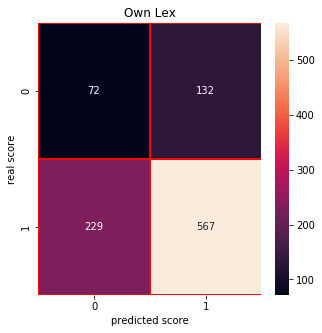

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot =True, linewidth = 0.5, linecolor = "red", fmt = ".0f", ax =ax)
plt.title("Own Lex")
plt.xlabel("predicted score")
plt.ylabel("real score")
plt.yticks( va="center")

model_info(y_test, y_pred)

,Accuracy,Specificity,Sensitivity
0,0.69,0.205882,0.81407


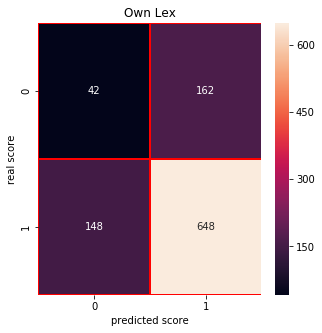

In [39]:
# Logistic Regression SGD
sgd = linear_model.SGDClassifier(max_iter=1000,tol=1e-3,loss='log',class_weight='balanced').fit(X_train_scaled, y_train)
y_pred2 = sgd.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred2)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot =True, linewidth = 0.5, linecolor = "red", fmt = ".0f", ax =ax)
plt.title("Own Lex")
plt.xlabel("predicted score")
plt.ylabel("real score")
plt.yticks( va="center")

model_info(y_test, y_pred2)

,Accuracy,Specificity,Sensitivity
0,0.204,1.0,0.0


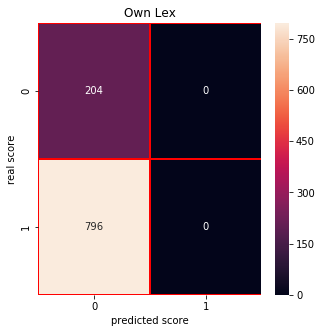

In [38]:
# SGD Modified Huber
sgd_huber = linear_model.SGDClassifier(max_iter=1000,tol=1e-3,alpha=20,loss='modified_huber',class_weight='balanced').fit(X_train_scaled, y_train)
y_pred3 = sgd_huber.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred3)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot =True, linewidth = 0.5, linecolor = "red", fmt = ".0f", ax =ax)
plt.title("Own Lex")
plt.xlabel("predicted score")
plt.ylabel("real score")
plt.yticks( va="center")

model_info(y_test, y_pred3)